In [6]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import StandardScaler
import cupy as cp

In [7]:
from alibi.explainers import ALE, plot_ale

ImportError: cannot import name 'formatargspec' from 'inspect' (/home/ineguiluz/anaconda3/envs/MLKernel/lib/python3.12/inspect.py)

## Interpretable Machine Learning

In this section we will pick the model with the best performance and we will have some insights about it. We will use the ALE plot to visualize the effect of each of the features on predictions. We are using this instead of PDPs because these last are sensitive to correlated data, which is very common in real life datasets.

First, we will load the model and the data.

In [93]:
data = pd.read_parquet('../data/processed/selected_features_df.parquet')
model = joblib.load("../models/randomForestClassifier.pkl")

X = data.drop(columns=['TARGET'])
y = data['TARGET']

feature_names = X.columns.tolist()

In [94]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [95]:
X_scaled = cp.asarray(X_scaled)
y = cp.asarray(y)

In [44]:
adasyn = ADASYN()
X, y = adasyn.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [45]:
model = model.fit(X_train, y_train)

In [54]:
rf_ale = ALE(model.predict, feature_names=feature_names, target_names=['Default', 'No Default'])

In [55]:
res = rf_ale.explain(X_train)

array([[<Axes: xlabel='NAME_CONTRACT_TYPE_Revolving loans', ylabel='ALE'>,
        <Axes: xlabel='CODE_GENDER_M', ylabel='ALE'>,
        <Axes: xlabel='NAME_TYPE_SUITE_Family', ylabel='ALE'>,
        <Axes: xlabel='NAME_TYPE_SUITE_Spouse, partner', ylabel='ALE'>],
       [<Axes: xlabel='NAME_TYPE_SUITE_Unaccompanied', ylabel='ALE'>,
        <Axes: xlabel='NAME_INCOME_TYPE_Pensioner', ylabel='ALE'>,
        <Axes: xlabel='NAME_INCOME_TYPE_State servant', ylabel='ALE'>,
        <Axes: xlabel='NAME_INCOME_TYPE_Working', ylabel='ALE'>],
       [<Axes: xlabel='NAME_EDUCATION_TYPE_Incomplete higher', ylabel='ALE'>,
        <Axes: xlabel='NAME_EDUCATION_TYPE_Lower secondary', ylabel='ALE'>,
        <Axes: xlabel='NAME_EDUCATION_TYPE_Secondary / secondary special', ylabel='ALE'>,
        <Axes: xlabel='NAME_FAMILY_STATUS_Married', ylabel='ALE'>],
       [<Axes: xlabel='NAME_FAMILY_STATUS_Separated', ylabel='ALE'>,
        <Axes: xlabel='NAME_FAMILY_STATUS_Single / not married', ylabel='ALE'>,


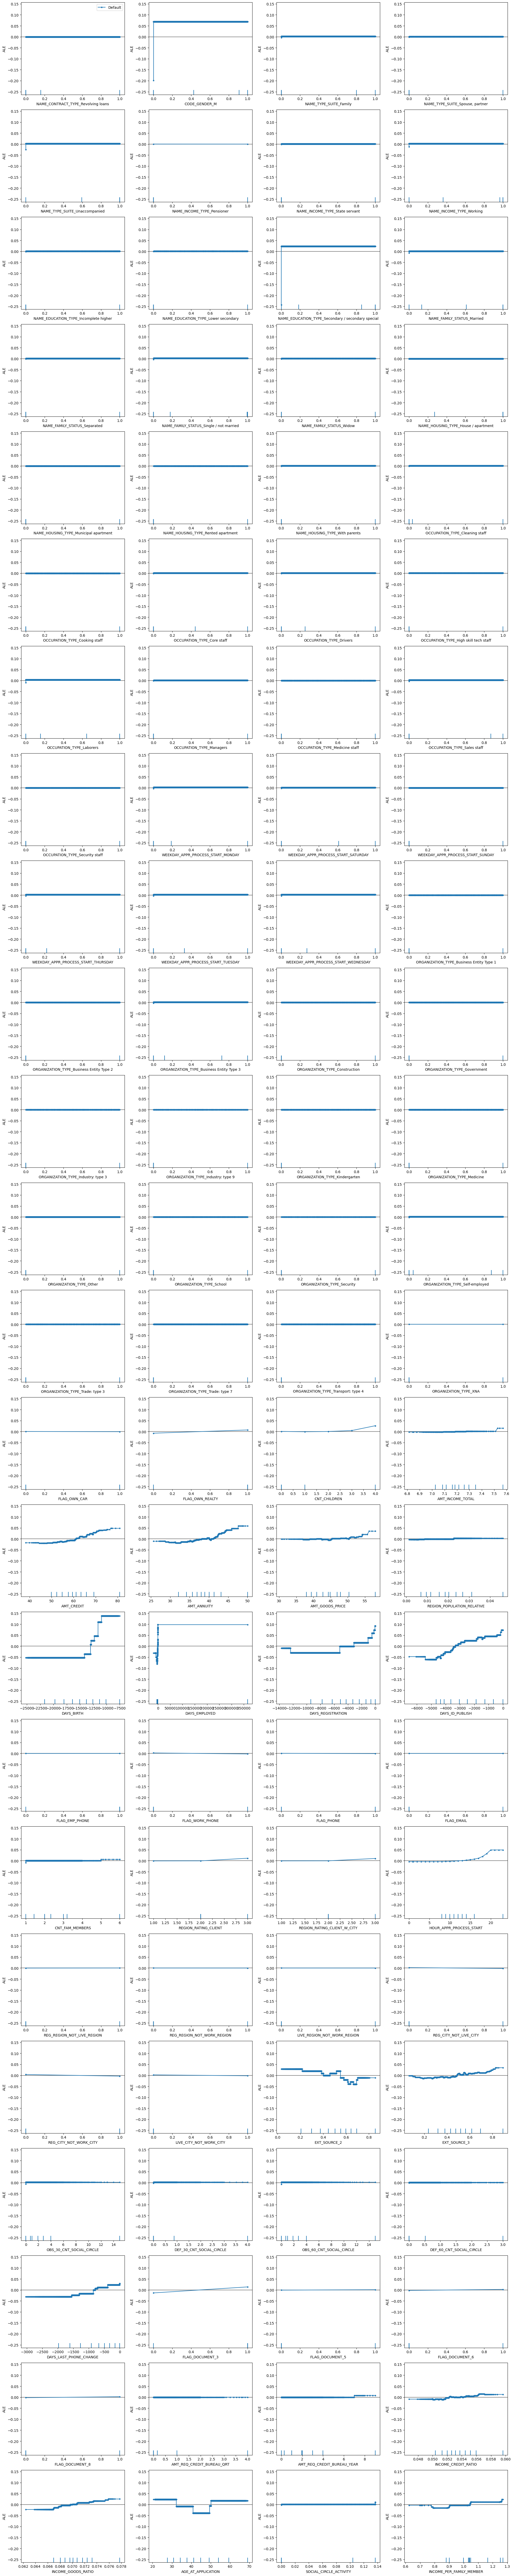

In [69]:
plot_ale(res, n_cols=4,targets=[0],fig_kw={'figwidth':20, 'figheight': 100})